In [65]:
import control as ctl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from scipy.optimize import fsolve
from tbcontrol.symbolic import routh
import pandas as pd
from time import time as millis

In [66]:
path = 'files/DataBase.csv'
df   = pd.read_csv(path)
df.head()

,pressure,time
0,355070.0,0.00
1,355256.0,0.09
2,355415.0,0.18
3,355510.0,0.28
4,355568.0,0.38


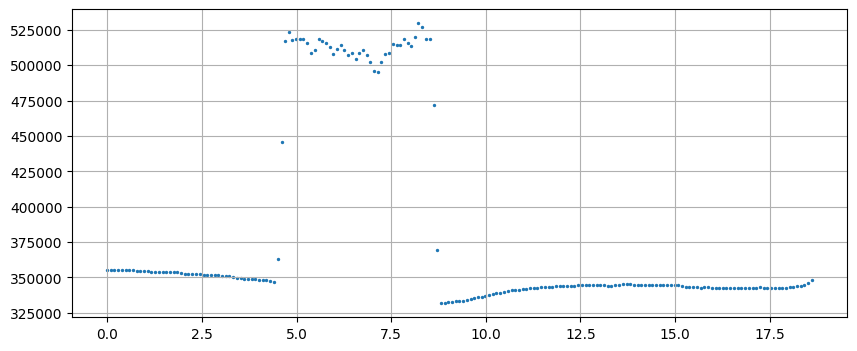

In [67]:
plt.figure(figsize=(10, 4))
plt.scatter(df.time, df.pressure, s=2)
plt.grid()

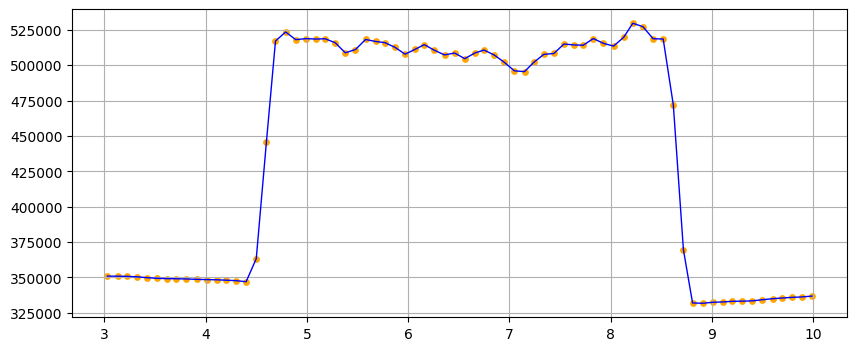

In [68]:
df = df.loc[(df.time > 3) & (df.time < 10)].reset_index(drop=True)

plt.figure(figsize=(10, 4))
plt.scatter(df.time, df.pressure, s=15, color='orange')
plt.plot(df.time, df.pressure, linewidth=1, color='blue')
plt.grid()

# ANÁLISE EM FREQUÊNCIA

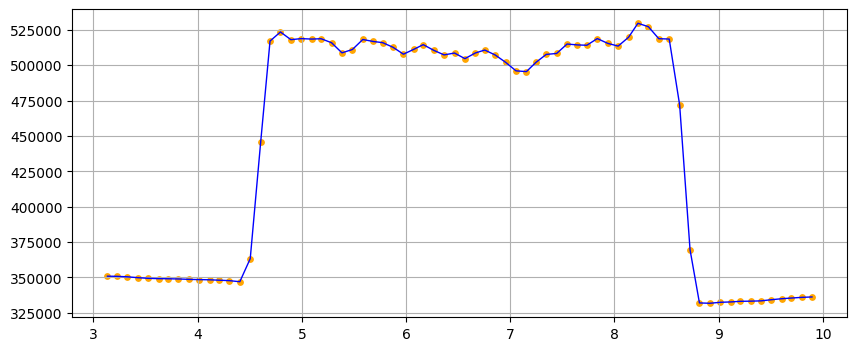

In [69]:
def normalizeData(time, response, T=0.01):
    timeIntervals = np.arange(np.min(time), np.max(time), T)
    xData = []
    yData = []

    for i in range(len(timeIntervals) - 1):
        position      = timeIntervals[i]
        next_position = timeIntervals[i + 1]

        target = response[(time > position) & (time <= next_position)]
        
        if len(target) == 0:
            continue
        
        t = (next_position + position)/2
        y = np.min(target)

        xData.append(t)
        yData.append(y)

    return xData, yData

period = 0.01
xData, yData = normalizeData(df.time, df.pressure, T=period)

plt.figure(figsize=(10, 4))
plt.scatter(xData, yData, s=15, color='orange')
plt.plot(xData, yData, linewidth=1, color='blue')
plt.grid()

### DOMÍNIO DA FREQUÊNCIA
- Fazendo a transformada de Fourier para obter os dados no domínio da frequência, onde o eixo horizontal indica a frequência e o eixo vertical indica a amplitude, geralmente as amplitudes maiores são os alvos desejados, perto de frequências baixas

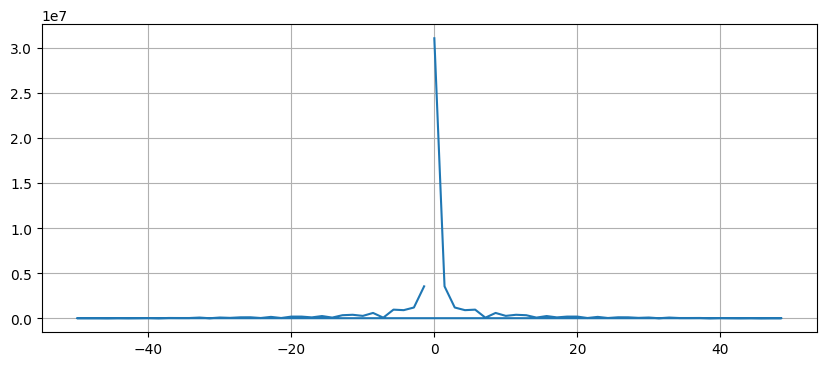

In [70]:
magnitude = np.fft.fft(yData)
frequency = np.fft.fftfreq(len(yData), period)

plt.figure(figsize=(10, 4))
plt.plot(frequency, np.abs(magnitude))
plt.grid()

### FILTRO PASSA BAIXA
- O gráfico acima apresenta enorme ruído depois da frequência principal do sistema, o objetivo é eliminar o ruído e impedir com que essas frequências sejam interpretadas

- Isso é feito escolhendo uma frequência de corte, em que tudo que está acima dessa frequência é bloqueado

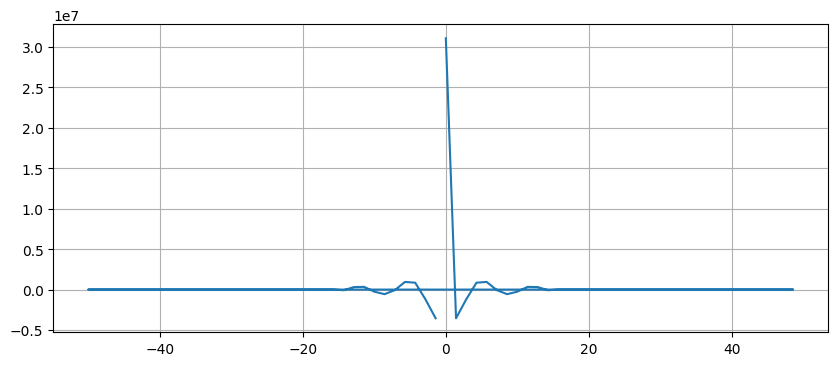

In [71]:
f_c = 15

def passaBaixa(frequencyArray, magnitudeArray, upperLimit):
    allowed = np.abs(frequencyArray) <= upperLimit
    magnitudeArray[~allowed] = 0
    return magnitudeArray


magnitude = passaBaixa(frequency, magnitude, f_c)
plt.figure(figsize=(10, 4))
plt.plot(frequency, magnitude.real)
plt.grid()

- Voltando para o domínio do tempo

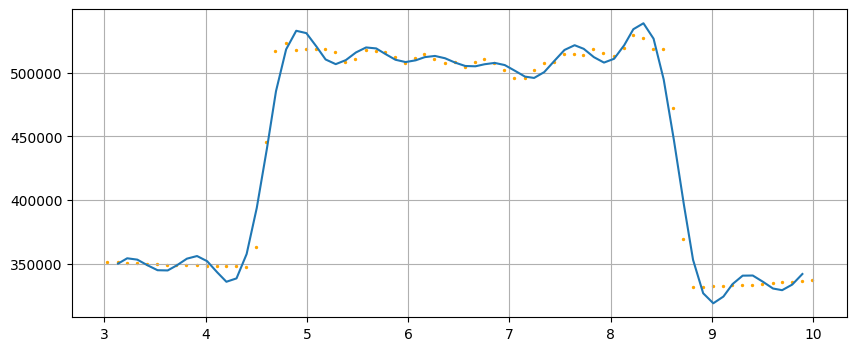

In [72]:
yData = np.fft.ifft(magnitude).real

plt.figure(figsize=(10, 4))
plt.plot(xData, yData)
plt.scatter(df.time, df.pressure, s=2, color='orange')
plt.grid()

# FILTRO DE FREQUÊNCIA
A função de transferência do filtro de segunda ordem tem cara: 

- $C(s) = \frac{\omega_n^2}{s^2 + 2\zeta\omega_n s + \omega_n^2}$ $\,\,\,\,\,\,\,\,\,$ onde $\omega_n$ é a frequência natural (ou frequência de corte) do filtro em rad/s.$

- Sabemos que para atenuação ideal, $|C|_{s \to j\omega_c} = \frac{1}{\sqrt{2}} = 0.707 = \zeta$

- Usando a frequência de corte $f_c = 0.1\,\text{Hz}$
- Com isso temos a frequência natural $\omega_c = 2\pi f_c$

In [73]:
w_c = 2*np.pi*f_c
f_c, w_c

(15, 94.24777960769379)

In [74]:
s = ctl.TransferFunction.s
w_n  = w_c
zeta = 0.7071067811865475

C = w_n**2 / (s**2 + 2*zeta*w_n*s + w_n**2)
C

TransferFunction(array([8882.64396098]), array([1.00000000e+00, 1.33286488e+02, 8.88264396e+03]))

### COMPARAÇÃO COM O FILTRO PADRÃO

TransferFunction(array([800.]), array([  1.,  40., 800.]))

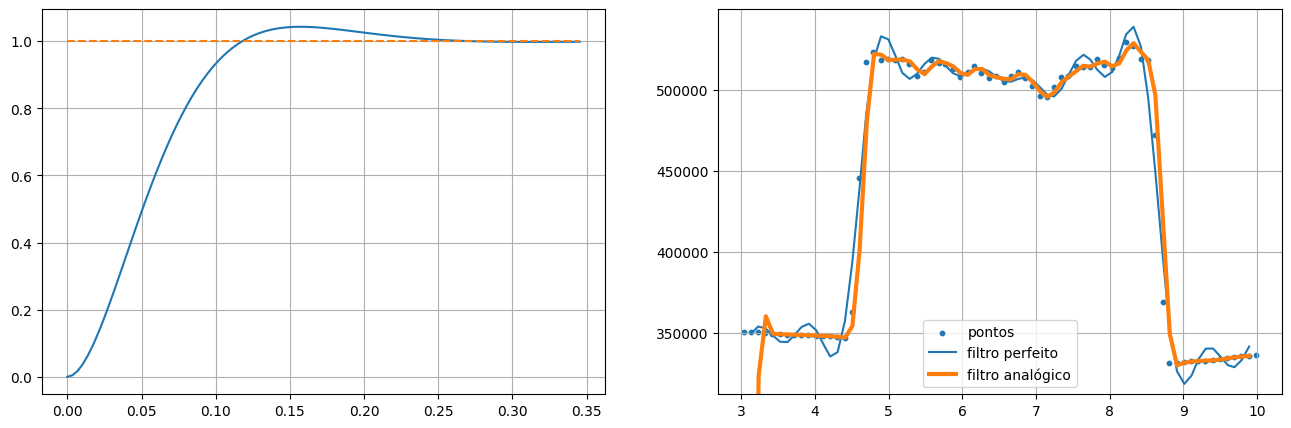

In [75]:
Ts   = .2
zeta = 0.7071067811865475
w_n  = 4/(zeta*Ts)

C = w_n**2 / (s**2 + 2*zeta*w_n*s + w_n**2)
display(C)

time, response = ctl.step_response(C)
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.plot(time, [1 for i in time], '--')
plt.grid()

xTest, yTest  = normalizeData(df.time, df.pressure, T=period)
timeArray     = np.linspace(xTest[0], xTest[-1], len(xTest))
time, reponse = ctl.forced_response(C, T=timeArray, U=yTest)

plt.subplot(1, 2, 2)
plt.scatter(df.time, df.pressure, s=10, label='pontos')
plt.plot(xData, yData, label='filtro perfeito')
plt.plot(time, reponse, label='filtro analógico', linewidth=3)

plt.ylim(min(yData)*0.98, max(yData)*1.02)
plt.legend()
plt.grid()

#### TESTE GRÁFICO
- O gráfico abaixo mostra que quando a frequência se aproxima da frequência $\omega_{desired}$, ocorre a atenuação

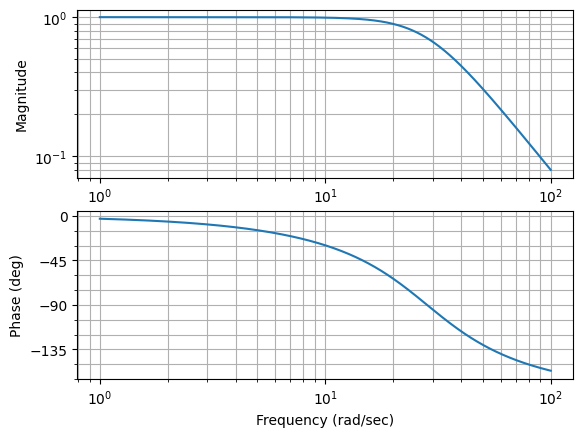

In [76]:
mag, fase, omega = ctl.bode(C, plot=True)

#### TESTE NUMÉRICO
- Vamos através dos vetores de magnitude e fase ver qual é a frequência onde ocorre a atenuação, obtendo a linha da tabela com a menor diferença entre o $\omega_{desired}$ que encontramos, e o $\omega$ da tabela. Vemos que nessa linha, a magnitude foi atenuada para um valor bem baixo
- A magnitude no ponto de frequência de corte deve ser igual a $\frac{1}{\sqrt{2}} = 0.707$ para a devida atenuação, vamos ver se isso realmente ocorre em $|C|_{s \to j\omega_c}$

In [77]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=10):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

1/np.sqrt(2)

0.7071067811865475

In [78]:
mag = sympyFunction(C).subs(s, sp.I*w_c)
mag = sp.N(sp.Abs(mag))
float(mag)

0.08970021224251627

### IMPLEMENTANDO DIGITALMENTE

In [79]:
T = 0.05
s = ctl.TransferFunction.s

C_z = ctl.c2d(C, T, method='zoh')
C_z

TransferFunction(array([0.49167401, 0.24612905]), array([ 1.        , -0.39753222,  0.13533528]), 0.05)

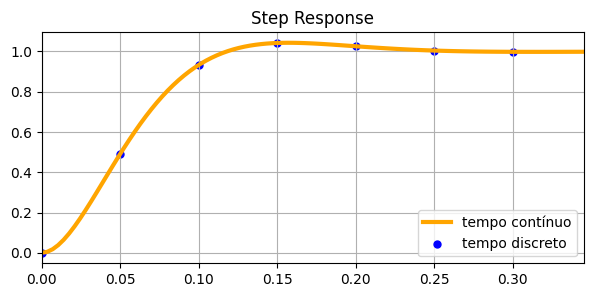

In [80]:
plt.figure(figsize=(7, 3))
time, response = ctl.step_response(C)

plt.plot(time, response, color='orange', linewidth=3, label='tempo contínuo')
plt.xlim(min(time), max(time))

time, response = ctl.step_response(C_z)
plt.scatter(time, response, color='blue', s=25, label='tempo discreto')

plt.title('Step Response')
plt.legend()
plt.grid()

In [81]:
num, den = ctl.tfdata(C_z)
num = np.squeeze(num)
den = np.squeeze(den)

num = num/den[0]
den = den/den[0]

if type(num) == np.float64:
    num = np.array([num])

print(num)
print(den)

[0.49167401 0.24612905]
[ 1.         -0.39753222  0.13533528]


In [82]:
def getDigitalFunction(num, den):
    out = ''
    for i in range(0, len(num)): out += f'{num[i]}*X_n{i} + '
    for i in range(1, len(den)): out += f'+ {-1*den[i]}*Y_n{i}'
    return out.replace('X_n0', 'X_n').replace('+ +', '+').replace('+ -', '-')


out = getDigitalFunction(num, den)
print(out + ';')

0.49167401400047483*X_n + 0.24612904854331208*X_n1 + 0.39753222069282557*Y_n1-0.13533528323661254*Y_n2;


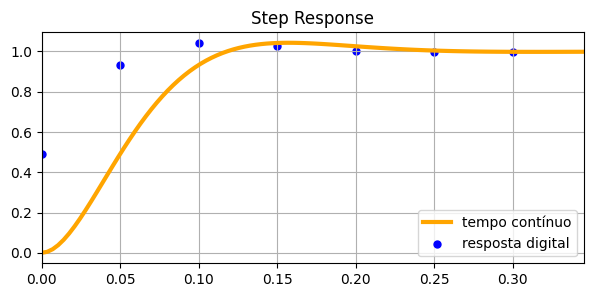

In [83]:
Y_n1 = Y_n2 = 0
X_n1 = X_n1 = 0

def compute(X_n):
    global Y_n1, X_n1, Y_n2, X_n2
    Y_n = eval(out)

    X_n2 = X_n1
    X_n1 = X_n

    Y_n2 = Y_n1
    Y_n1 = Y_n
    return Y_n


plt.figure(figsize=(7, 3))
time, response = ctl.step_response(C)
plt.plot(time, response, color='orange', linewidth=3, label='tempo contínuo')
plt.xlim(min(time), max(time))

time     = np.arange(0, 20, T)
response = [compute(1) for i in time] 
plt.scatter(time, response, color='blue', s=25, label='resposta digital')

plt.title('Step Response')
plt.grid()
plt.legend()
plt.show()

### COMPARAÇÃO COM O FILTRO PERFEITO

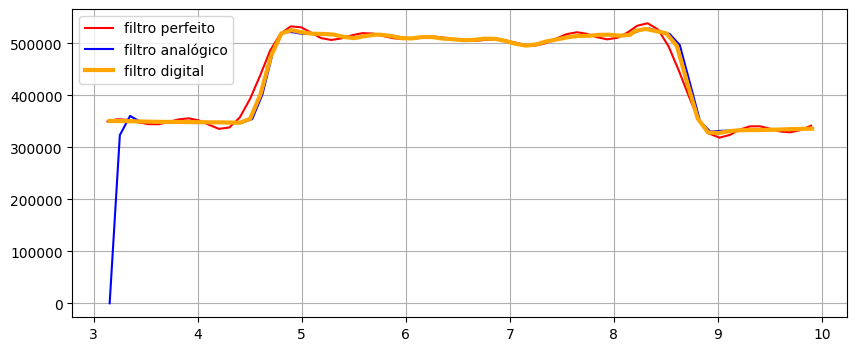

In [84]:
xTest, yTest  = normalizeData(df.time, df.pressure, T=T)
timeArray     = np.linspace(xTest[0], xTest[-1], len(xTest))
time, reponse = ctl.forced_response(C, T=timeArray, U=yTest)
for i in range(100): compute(yTest[0]) # RECALIBRANDO

plt.figure(figsize=(10, 4))
plt.plot(xData, yData, label='filtro perfeito', color='red')
plt.plot(time, reponse, label='filtro analógico', color='blue')
plt.plot(xTest, [compute(y) for y in yTest], label='filtro digital', color='orange', linewidth=3)
plt.legend()
plt.grid()

### COMPARAÇÃO DOS DADOS

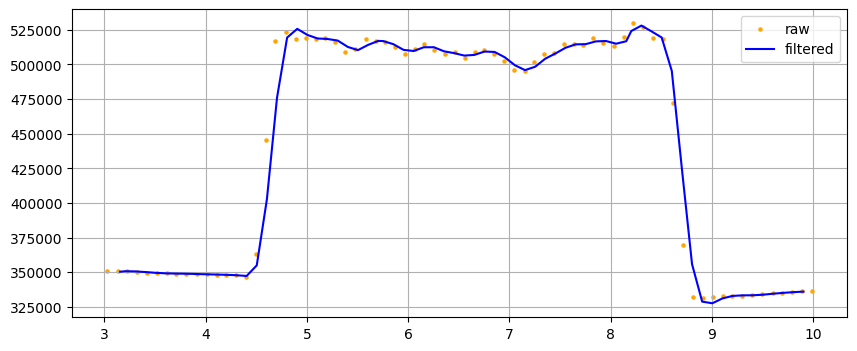

In [85]:
for i in range(100): compute(yData[0]) # RECALIBRANDO

plt.figure(figsize=(10, 4))
plt.scatter(df.time, df.pressure, color='orange', s=5, label='raw')
plt.plot(xTest, [compute(y) for y in yTest], color='blue', label='filtered')

plt.grid()
plt.legend()